# Purpose
The purpose of this file is to clean and manage data the 2008-2010 Medicare Claims Synthetic Public Use Files (SynPUFs).

# Setup
First, we'll import the packages we'll need for data management tasks.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Beneficiary Summary File

## Load data and codebook

Next, we will load the 2008 Beneficiary Summary file into Python.

In [2]:
# load the Beneficiary Summary files
beneficiary = pd.read_csv("data/2008_Beneficiary_Summary_File_Sample_1.csv")

Then we will load in the Beneficiary Summary File **codebook**, which will be used to efficiently rename variable (column) names into names that are more easily readable.

In [3]:
# load the codebook file
codebook_beneficiary = pd.read_excel("codebooks/analysis_codebook.xlsx",
                                     sheet_name = "Beneficiary")

In [4]:
# create a function to use values from the codebook to rename columns
# we will use the 'old_name' column (original column names) to rename the columns in the dataframe
def rename_columns(df, codebook):
    # Create a mapping from old names to new names
    name_mapping = dict(zip(codebook['old_name'], 
                            codebook['new_name']))
    # Rename the columns in the dataframe
    df.rename(columns=name_mapping, 
              inplace=True)
    return df


# run the function
beneficiary = rename_columns(df = beneficiary, 
                             codebook = codebook_beneficiary)

Now we'll examine summary information about the datasets, including the number of rows/columns, the data types of each variable, and the first few rows of each dataset.

## Variable recoding

First, we'll merge the US state name and abbreviation by the US state FIPS code that was already included in the Beneficiary Summary Files.

In [5]:
# load the US State FIPS code file
fips = pd.read_excel("codebooks/analysis_codebook.xlsx",
                     sheet_name = "State FIPS Codes")

# merge the `fips` data frame with the merged data
beneficiary = pd.merge(beneficiary, 
                       fips, 
                       how='left', 
                       left_on='state_code', 
                       right_on='state_code')


In [6]:
# summarize the US states in the merged data in a table
state_summary = beneficiary['state_name'].value_counts().reset_index()  
state_summary.columns = ['State Name', 
                         'Count'] 
# sort the summary by count in descending order
state_summary = state_summary.sort_values(by='State Name', 
                                          ascending=True)
# display the state summary
print("-- State Summary --")
print(state_summary)

-- State Summary --
              State Name  Count
13               Alabama   2570
46                Alaska    244
20               Arizona   1851
0               Arkansas  10224
17            California   2012
41              Colorado    493
45           Connecticut    310
1               Delaware   7745
9   District of Columbia   3012
39               Florida    544
36               Georgia    675
14                Hawaii   2497
28                 Idaho   1317
30              Illinois   1142
19               Indiana   1864
24                  Iowa   1715
35                Kansas    692
22              Kentucky   1837
12             Louisiana   2587
6                  Maine   4012
18              Maryland   1982
27         Massachusetts   1331
15              Michigan   2378
42             Minnesota    429
34           Mississippi    713
33              Missouri    842
38               Montana    644
8               Nebraska   3176
31                Nevada   1119
3          New Hamps

Next, we'll recode birthdate variable to obtain an integer age value for the current year (2008, 2009, or 2010).

In [7]:
# create a new variable named `age` that is the age of the beneficiary
# first, extract the year from the birthdate column
beneficiary['birth_year'] = beneficiary['birthdate'] // 10000
# next, subtract the birth year from the year to get their current age (assuming the current year is 2008)
beneficiary['age'] = 2008 - beneficiary['birth_year']

# check that the values were assigned correctly
print("-- Age Summary --") 
print(beneficiary['age'].describe().round(2))

# print the first 10 rows of the relevant columns
print("\n", "-- First 10 Rows of the Age-related Columns --")
print(beneficiary[['birthdate', 'birth_year', 'age']].head(10))

-- Age Summary --
count    116352.00
mean         71.65
std          12.50
min          25.00
25%          66.00
50%          72.00
75%          80.00
max          99.00
Name: age, dtype: float64

 -- First 10 Rows of the Age-related Columns --
   birthdate  birth_year  age
0   19230501        1923   85
1   19430101        1943   65
2   19360901        1936   72
3   19410601        1941   67
4   19360801        1936   72
5   19431001        1943   65
6   19220701        1922   86
7   19350901        1935   73
8   19760901        1976   32
9   19381001        1938   70


Next, we will make a categorical age group variable with the following levels:
*   Age < 65
*   Age 65-74
*   Age 75-84
*   Age 85+

In [8]:
# Define ordered categories explicitly
age_labels = ['< 65', '65-74', '75-84', '85+']

# Create the age_group with labels as strings (not as pd.Categorical)
beneficiary['age_group'] = pd.cut(beneficiary['age'], 
                                  bins=[0, 64, 74, 84, 100], 
                                  labels=age_labels, 
                                  right=False)

# Explicitly convert age_group column to a categorical dtype with the right order
beneficiary['age_group'] = beneficiary['age_group'].cat.set_categories(age_labels, ordered=True)

# Now count without sorting, then sort_index() respects the ordered categories
print("\n-- Age Group Summary --")
age_group_counts = beneficiary['age_group'].value_counts(sort=False).sort_index()
age_group_percent = (age_group_counts / age_group_counts.sum() * 100).round(2)
age_group_summary = pd.DataFrame({'Count': age_group_counts, 
                                  'Percent': age_group_percent})
print(age_group_summary)


-- Age Group Summary --
           Count  Percent
age_group                
< 65       18242    15.68
65-74      46070    39.60
75-84      34332    29.51
85+        17708    15.22


Now we will recode values of the race/ethnicity and sex into categorical format.

In [9]:
# Sex recoding
beneficiary['sex'] = beneficiary['sex'].replace({1: 'Male', 
                                                 2: 'Female'}).astype('category')
# Race/ethnicity recoding
beneficiary['race'] = beneficiary['race'].replace({1: 'White', 
                                                   2: 'Black',
                                                   3: 'Other race',
                                                   5: 'Hispanic'}).astype('category')

In [10]:
# Check that the new values are coded correctly
print(beneficiary['sex'].value_counts(),
      "\n\n",
      beneficiary['race'].value_counts())

sex
Female    64347
Male      52005
Name: count, dtype: int64 

 race
White         96349
Black         12343
Other race     4931
Hispanic       2729
Name: count, dtype: int64


Finally, we will recode the health condition columns so that the values have categorical values. For each, 1 = Yes and 2 = No.

In [11]:
# grab the column names from the merged data to see which conditions are available
beneficiary.columns.tolist()

['person_id',
 'birthdate',
 'deathdate',
 'sex',
 'race',
 'end_stage_renal_disease',
 'state_code',
 'county_code',
 'months_part_a_coverage',
 'months_part_b_coverage',
 'months_hmo_coverage',
 'months_part_d_coverage',
 'dementia',
 'heart_failure',
 'kidney_disease',
 'cancer',
 'copd',
 'depression',
 'diabetes',
 'ischemic_heart_disease',
 'osteoporosis',
 'arthritis',
 'stroke',
 'annual_inpatient_reimbursement',
 'annual_inpatient_responsibility',
 'annual_inpatient_primary_payer_reimbursement',
 'annual_outpatient_reimbursement',
 'annual_outpatient_responsibility',
 'annual_outpatient_primary_payer_reimbursement',
 'annual_carrier_reimbursement',
 'annual_carrier_responsibility',
 'annual_carrier_primary_payer_responsibility',
 'state_name',
 'state_abbrev',
 'birth_year',
 'age',
 'age_group']

In [30]:
conditions = ['dementia', 'heart_failure', 'kidney_disease',
              'cancer', 'copd', 'depression', 
              'diabetes', 'ischemic_heart_disease', 'osteoporosis',
              'arthritis', 'stroke']

for condition in conditions:
    beneficiary[condition] = beneficiary[condition].replace({1: 'Yes',
                                                             2: 'No'}).astype('category')
# Check that the new values are coded correctly 
print("\n-- Conditions Summary --")
# Loop through each condition to summarize the counts and percentages
for condition in conditions:
    counts = beneficiary[condition].value_counts()
    print(counts)
    percent = (counts.get("Yes", 0) / counts.sum() * 100).round(2)
    print(f"{percent}%", "\n")



-- Conditions Summary --
dementia
No     93942
Yes    22410
Name: count, dtype: int64
19.26% 

heart_failure
No     83197
Yes    33155
Name: count, dtype: int64
28.5% 

kidney_disease
No     97666
Yes    18686
Name: count, dtype: int64
16.06% 

cancer
No     108937
Yes      7415
Name: count, dtype: int64
6.37% 

copd
No     100609
Yes     15743
Name: count, dtype: int64
13.53% 

depression
No     91512
Yes    24840
Name: count, dtype: int64
21.35% 

diabetes
No     72292
Yes    44060
Name: count, dtype: int64
37.87% 

ischemic_heart_disease
No     67410
Yes    48942
Name: count, dtype: int64
42.06% 

osteoporosis
No     96175
Yes    20177
Name: count, dtype: int64
17.34% 

arthritis
No     98436
Yes    17916
Name: count, dtype: int64
15.4% 

stroke
No     111129
Yes      5223
Name: count, dtype: int64
4.49% 



# Inpatient Claims Data

## Load the data and codebook

In [13]:
# Load the inpatient claims file
inpatient = pd.read_csv("data/2008_to_2010_Inpatient_Claims_Sample_1.csv")

In [14]:
codebook_inpatient = pd.read_excel("codebooks/analysis_codebook.xlsx",
                                   sheet_name="Inpatient")

In [15]:
# rename the columns in the inpatient claims data using the codebook
inpatient = rename_columns(df = inpatient, 
                           codebook = codebook_inpatient)

# select only the variables listed in the codebook to be in the final inpatient data frame
inpatient_columns = codebook_inpatient['new_name'].tolist()
inpatient = inpatient[inpatient_columns]

# find the column names in the inpatient claims file
print("\n-- Inpatient Claims Columns --")
print(inpatient.columns.tolist())


-- Inpatient Claims Columns --
['person_id', 'claim_start', 'claim_end', 'claim_payment_amount', 'primary_payer_amount', 'deductible_amount', 'coinsurance_amount', 'blood_deductible_amount', 'inpatient_admission_date', 'inpatient_discharge_date', 'admitting_icd9_code', 'claim_utilization_day_count', 'icd9_diagnosis_1', 'icd9_diagnosis_2', 'icd9_diagnosis_3', 'icd9_diagnosis_4', 'icd9_diagnosis_5', 'icd9_diagnosis_6', 'icd9_diagnosis_7', 'icd9_diagnosis_8', 'icd9_diagnosis_9', 'icd9_diagnosis_10', 'icd9_procedure_1', 'icd9_procedure_2', 'icd9_procedure_3', 'icd9_procedure_4', 'icd9_procedure_5', 'icd9_procedure_6', 'hcpcs_1', 'hcpcs_2', 'hcpcs_3', 'hcpcs_4', 'hcpcs_5', 'hcpcs_6', 'hcpcs_7', 'hcpcs_8', 'hcpcs_9', 'hcpcs_10', 'hcpcs_11', 'hcpcs_12', 'hcpcs_13', 'hcpcs_14', 'hcpcs_15', 'hcpcs_16', 'hcpcs_17', 'hcpcs_18', 'hcpcs_19', 'hcpcs_20', 'hcpcs_21', 'hcpcs_22', 'hcpcs_23', 'hcpcs_24', 'hcpcs_25', 'hcpcs_26', 'hcpcs_27', 'hcpcs_28', 'hcpcs_29', 'hcpcs_30', 'hcpcs_31', 'hcpcs_32', 'h

# Create analytic dataset

For this analysis, we will seek to answer the following research question: 

*   **Natural language processing:**  Using natural language processing (NLP) methods, what are the most common clusters of inpatient procedure codes among hospitalized diabetic patients?
*   **Subgroup analysis:** How do the NLP-identified procedure code clusters vary by age, sex, race, and comorbidity burden among diabetic patients?
*   **Expenditure analysis:** What is the association between the NLP-identified procedure code clusters and total inpatient expenditures among diabetic patients?

Prior to conducting analysis, we will limit the dataset to:
*   Patients with diagnosed diabetes in the 2008 Beneficiary Summary File.
*   Patients with inpatient hospitalization records.
*   Inpatient hospitalization records in 2008.

In [16]:
# Step 1: Limit the Beneficiary summary file to those with diagnosed diabetes
diabetes_beneficiaries = beneficiary.query("diabetes == 'Yes'").copy()

In [17]:
# Step 2: Limit the inpatient claims file to those with diagnosed diabetes
# First, grab the person IDs of beneficiaries with diabetes
diabetes_ids = diabetes_beneficiaries['person_id']

# Merge the diabetes beneficiaries with the inpatient claims data
diabetes_inpatient = inpatient[inpatient['person_id'].isin(diabetes_ids)].copy()

In [18]:
# Step 3: Limit the inpatient claims data to those with inpatient hospitalizations in 2008
# create a new variable named `age` that is the age of the beneficiary
diabetes_inpatient['claim_year_start'] = diabetes_inpatient['claim_start'] // 10000
diabetes_inpatient['claim_year_end'] = diabetes_inpatient['claim_end'] // 10000

# check that the values were assigned correctly
print("-- Claim Year Summaries --", "\n") 
print(diabetes_inpatient['claim_year_start'].value_counts())
print("\n")
print(diabetes_inpatient['claim_year_end'].value_counts())

-- Claim Year Summaries -- 

claim_year_start
2008.0    23023
2009.0    17097
2010.0     8099
2007.0      198
Name: count, dtype: int64


claim_year_end
2008.0    22920
2009.0    17178
2010.0     8319
Name: count, dtype: int64


In [19]:
# Limit the inpatient claims data to those with inpatient hospitalizations in 2008
diabetes_inpatient = diabetes_inpatient[(diabetes_inpatient['claim_year_start'] == 2008) | 
                                        (diabetes_inpatient['claim_year_end'] == 2008)]

Finally, we will limit the Beneficiary Summary File to only include those with valid inpatient hospitalization claims in 2008. We will use the person_id records from `diabetes_inpatient` file to assist here.

In [20]:
# Extract the person IDs from the inpatient data
diabetes_inpatient_ids = diabetes_inpatient['person_id']

# Merge the diabetes beneficiaries with the inpatient claims data
diabetes_beneficiaries = diabetes_beneficiaries[diabetes_beneficiaries['person_id'].
                                            isin(diabetes_inpatient_ids)].copy()

## Save the analytic data files

In [21]:
# Save the diabetes beneficiaries data to a CSV file
diabetes_beneficiaries.to_csv("data/analysis_data/diabetes_beneficiaries.csv", index=False)

# Save the inpatient claims data to a CSV file
diabetes_inpatient.to_csv("data/analysis_data/diabetes_inpatient.csv", index=False)

# Data exploration

Now we'll examine summary information about the datasets, including the number of rows/columns, the data types of each variable, and the first few rows of each dataset.

In [22]:
# Create a data dictionary with the Beneficiary Summary File name(s).
datasets = {
    "2008 Beneficiary Summary File": diabetes_beneficiaries,
    "2008 Inpatient Claims for Diabetes Beneficiaries": diabetes_inpatient
}

# Loop through each Beneficary Summary file to summarize the number of rows/columns.
for name, data in datasets.items():
    rows, cols = data.shape
    print(f"Dataset name: {name}")
    print(f"Number of rows: {rows}")
    print(f"Number of columns: {cols}")
    print("Variable (column) names:", data.columns.tolist())
    print("") # add an extra space between output to improve clarity

Dataset name: 2008 Beneficiary Summary File
Number of rows: 12499
Number of columns: 37
Variable (column) names: ['person_id', 'birthdate', 'deathdate', 'sex', 'race', 'end_stage_renal_disease', 'state_code', 'county_code', 'months_part_a_coverage', 'months_part_b_coverage', 'months_hmo_coverage', 'months_part_d_coverage', 'dementia', 'heart_failure', 'kidney_disease', 'cancer', 'copd', 'depression', 'diabetes', 'ischemic_heart_disease', 'osteoporosis', 'arthritis', 'stroke', 'annual_inpatient_reimbursement', 'annual_inpatient_responsibility', 'annual_inpatient_primary_payer_reimbursement', 'annual_outpatient_reimbursement', 'annual_outpatient_responsibility', 'annual_outpatient_primary_payer_reimbursement', 'annual_carrier_reimbursement', 'annual_carrier_responsibility', 'annual_carrier_primary_payer_responsibility', 'state_name', 'state_abbrev', 'birth_year', 'age', 'age_group']

Dataset name: 2008 Inpatient Claims for Diabetes Beneficiaries
Number of rows: 23221
Number of columns: 7

In [23]:
# Generate univariate summaries for the diabetes beneficiaries
# Include race, sex, and all of the conditions except diabetes
variables = ['race', 'sex'] + [cond for cond in conditions if cond != 'diabetes']

# Step 3: Create a summary table for each variable
print("\n-- Summary of Diabetes Beneficiaries --")
for var in variables:
    print(f"\nSummary of {var}:")
    counts = diabetes_beneficiaries[var].value_counts(dropna=False)
    percent = (counts / counts.sum() * 100).round(2)
    summary = pd.DataFrame({'Count': counts, 'Percent': percent})
    print(summary)


-- Summary of Diabetes Beneficiaries --

Summary of race:
            Count  Percent
race                      
White       10551    84.41
Black        1326    10.61
Other race    352     2.82
Hispanic      270     2.16

Summary of sex:
        Count  Percent
sex                   
Female   7119    56.96
Male     5380    43.04

Summary of dementia:
          Count  Percent
dementia                
Yes        6923    55.39
No         5576    44.61

Summary of heart_failure:
               Count  Percent
heart_failure                
Yes             9932    79.46
No              2567    20.54

Summary of kidney_disease:
                Count  Percent
kidney_disease                
Yes              7990    63.93
No               4509    36.07

Summary of cancer:
        Count  Percent
cancer                
No       9904    79.24
Yes      2595    20.76

Summary of copd:
      Count  Percent
copd                
Yes    6912     55.3
No     5587     44.7

Summary of depression:
           

Examine the age distribution of the diabetic patient sample.

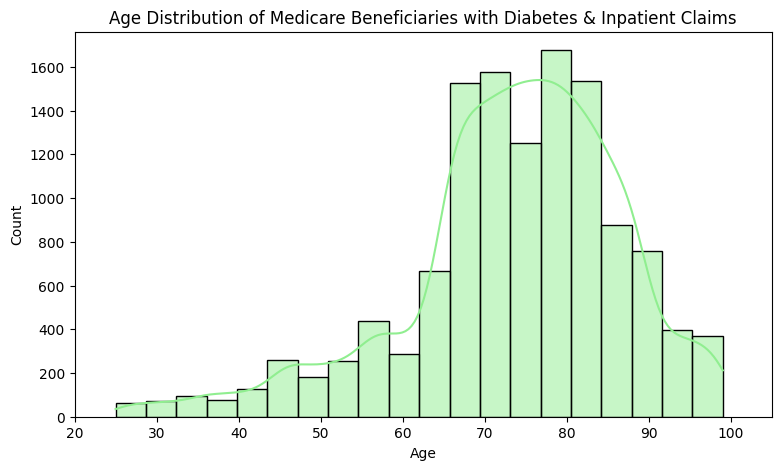

In [24]:
# Examine the age distribution of beneficiaries with diabetes
plt.figure(figsize=(9, 5))
sns.histplot(data=diabetes_beneficiaries, 
             x='age', 
             bins=20, 
             kde=True, 
             color='lightgreen')
plt.title("Age Distribution of Medicare Beneficiaries with Diabetes & Inpatient Claims")
plt.xlabel("Age")
plt.ylabel("Count")
plt.xlim(20, 105)
plt.show()

Now we will examine comorbid health conditions (e.g., diabetes, cancer) among patients with diabetes in the Beneficiary Summary Files by sex, race, and age group.

In [25]:
# First, create a function to get the row percentages of a crosstab
def get_row_percent_crosstab(df, col_vars, row_var):
    # Create the crosstab
    crosstab = pd.crosstab(df[row_var], df[col_vars])

    # Calculate row percentages
    row_percentages = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

    # Add total percentage column (should always be 100, but nice for validation)
    row_percentages['Total'] = row_percentages.sum(axis=1)

    return row_percentages

In [26]:
# Next, create a function to generate and print row-percentage crosstabs for each 
# condition against a specified row variable
def generate_and_print_crosstabs(df, col_vars, row_var):
    """
    Generate and print row-percentage crosstabs for each condition against a specified row variable.
    
    Parameters:
    - df: DataFrame containing the data
    - col_vars: list of variables to use as the columns in the crosstab (e.g., conditions)
    - row_var: the variable to use as rows in the crosstab (e.g., 'race', 'sex', etc.)
    
    Returns:
    - Dictionary of crosstab tables
    """
    results = {}
    for var in col_vars:
        results[var] = get_row_percent_crosstab(df = df,
                                                col_vars = var,
                                                row_var=row_var)
        print(f"\n--- {var.upper()} Crosstab ---")
        print(results[var])

In [27]:
# Summarize comorbidities by sex
generate_and_print_crosstabs(df = diabetes_beneficiaries,
                             col_vars = conditions,
                             row_var = 'sex')


--- DEMENTIA Crosstab ---
dementia         No        Yes  Total
sex                                  
Female    44.472538  55.527462  100.0
Male      44.795539  55.204461  100.0

--- HEART_FAILURE Crosstab ---
heart_failure         No        Yes  Total
sex                                       
Female         20.915859  79.084141  100.0
Male           20.037175  79.962825  100.0

--- KIDNEY_DISEASE Crosstab ---
kidney_disease         No        Yes  Total
sex                                        
Female          36.451749  63.548251  100.0
Male            35.576208  64.423792  100.0

--- CANCER Crosstab ---
cancer         No        Yes  Total
sex                                
Female  79.575783  20.424217  100.0
Male    78.791822  21.208178  100.0

--- COPD Crosstab ---
copd           No        Yes  Total
sex                                
Female  44.697289  55.302711  100.0
Male    44.702602  55.297398  100.0

--- DEPRESSION Crosstab ---
depression         No        Yes  Total
sex

In [28]:
# Summarize comorbidities by race
generate_and_print_crosstabs(df = diabetes_beneficiaries,
                             col_vars = conditions,
                             row_var = 'race')


--- DEMENTIA Crosstab ---
dementia           No        Yes  Total
race                                   
Black       44.042232  55.957768  100.0
Hispanic    40.740741  59.259259  100.0
Other race  42.045455  57.954545  100.0
White       44.867785  55.132215  100.0

--- HEART_FAILURE Crosstab ---
heart_failure         No        Yes  Total
race                                      
Black          18.325792  81.674208  100.0
Hispanic       20.740741  79.259259  100.0
Other race     22.727273  77.272727  100.0
White          20.737371  79.262629  100.0

--- KIDNEY_DISEASE Crosstab ---
kidney_disease         No        Yes  Total
race                                       
Black           33.182504  66.817496  100.0
Hispanic        37.407407  62.592593  100.0
Other race      36.079545  63.920455  100.0
White           36.404132  63.595868  100.0

--- CANCER Crosstab ---
cancer             No        Yes  Total
race                                   
Black       78.054299  21.945701  100.0
H

In [29]:
# Summarize comorbidities by age group
generate_and_print_crosstabs(df = diabetes_beneficiaries,
                             col_vars = conditions,
                             row_var = 'age_group')


--- DEMENTIA Crosstab ---
dementia          No        Yes  Total
age_group                             
< 65       42.130751  57.869249  100.0
65-74      48.344557  51.655443  100.0
75-84      44.071146  55.928854  100.0
85+        42.487597  57.512403  100.0

--- HEART_FAILURE Crosstab ---
heart_failure         No        Yes  Total
age_group                                 
< 65           20.484262  79.515738  100.0
65-74          23.148148  76.851852  100.0
75-84          19.812253  80.187747  100.0
85+            18.320340  81.679660  100.0

--- KIDNEY_DISEASE Crosstab ---
kidney_disease         No        Yes  Total
age_group                                  
< 65            35.108959  64.891041  100.0
65-74           39.702581  60.297419  100.0
75-84           34.955534  65.044466  100.0
85+             33.805811  66.194189  100.0

--- CANCER Crosstab ---
cancer            No        Yes  Total
age_group                             
< 65       79.225182  20.774818  100.0
65-74     